Import Required Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


Define Dataset Paths

In [3]:
# Define dataset paths
train_dir = "extract folder/train"
test_dir = "extract folder/test"


Create DataFrames (Optional)

In [4]:
def create_dataframe(directory):
    data = []
    categories = os.listdir(directory)
    
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                data.append([img_path, category])

    return pd.DataFrame(data, columns=["image_path", "label"])

# Create DataFrames
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Display first few rows
print(train_df.head())



                                         image_path  label
0  extract folder/train\angry\Training_10118481.jpg  angry
1  extract folder/train\angry\Training_10120469.jpg  angry
2  extract folder/train\angry\Training_10131352.jpg  angry
3  extract folder/train\angry\Training_10161559.jpg  angry
4   extract folder/train\angry\Training_1021836.jpg  angry


Load and Preprocess Image Data

In [5]:
# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Print class labels
print("Class Labels:", train_generator.class_indices)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Build the CNN Model

In [6]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()



c:\Users\HIMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,911 (2.64 MB)

 Trainable params: 691,911 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Train the CNN Model

In [7]:
# Train the model
history = model.fit(train_generator,epochs=25,                                                           # Increase for better accuracy
                    validation_data=test_generator)


c:\Users\HIMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 280s 310ms/step - accuracy: 0.2254 - loss: 1.8592 - val_accuracy: 0.2577 - val_loss: 1.7991
Epoch 2/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 206s 229ms/step - accuracy: 0.2426 - loss: 1.8142 - val_accuracy: 0.2541 - val_loss: 1.7865
Epoch 3/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 180s 201ms/step - accuracy: 0.2492 - loss: 1.8043 - val_accuracy: 0.2588 - val_loss: 1.7646
Epoch 4/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 211s 235ms/step - accuracy: 0.2579 - loss: 1.7823 - val_accuracy: 0.2906 - val_loss: 1.7414
Epoch 5/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 267s 297ms/step - accuracy: 0.2606 - loss: 1.7736 - val_accuracy: 0.3026 - val_loss: 1.7385
Epoch 6/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 258s 287ms/step - accuracy: 0.2655 - loss: 1.7669 - val_accuracy: 0.3213 - val_loss: 1.6968
Epoch 7/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 253s 281ms/step - accuracy: 0.2716 - loss: 1.7592 - val_accuracy: 0.3160 - val_loss: 1.6860
Epoch 8/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 252s 281ms/step - accuracy: 0.2807 -

 Evaluate the Model

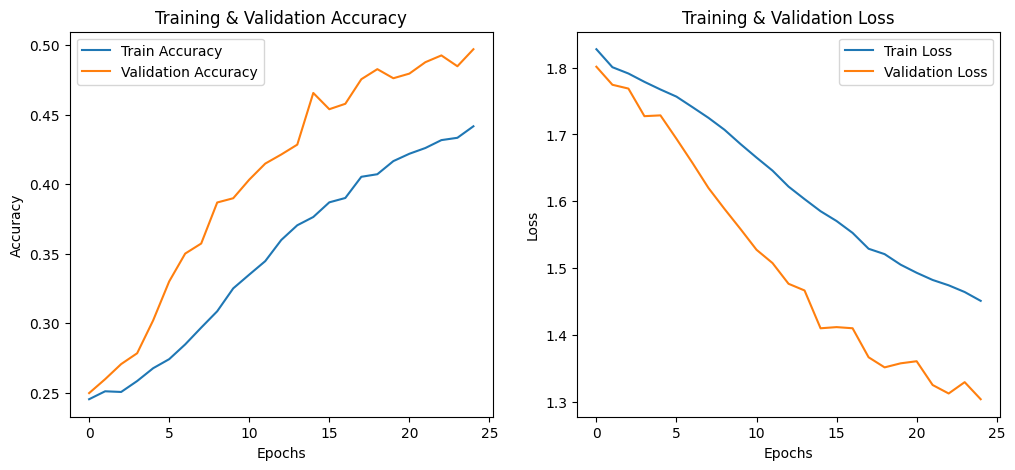

In [9]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()



Save and Load the Model

In [10]:
# Save the trained model
model.save("emotion_detection_cnn.h5")

# Load the model for later use
loaded_model = load_model("emotion_detection_cnn.h5")



Predict Emotion from an Image

In [13]:
def predict_emotion(img_path, model, class_labels):
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    return class_labels[predicted_class]

# Test on a new image
img_path = "extract folder/test/sad/PrivateTest_27121750.jpg"  # Change this
predicted_emotion = predict_emotion(img_path, loaded_model, list(train_generator.class_indices.keys()))
print(f"Predicted Emotion: {predicted_emotion}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Emotion: sad


In [29]:
def predict_emotion(img_path, model, class_labels):
    img = load_img(img_path, target_size=(64, 64))  # Resize
    img_array = img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions
    img_array /= 255.0  # Normalize (match training)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)  # Get confidence score

    print(f"Predictions: {prediction}")
    print(f"Predicted Emotion: {class_labels[predicted_class]} with {confidence*100:.2f}% confidence")
    
    return class_labels[predicted_class]

# Test on an image
img_path = "extract folder/test/happy/PrivateTest_3447769.jpg"
class_labels = list(train_generator.class_indices.keys())  # Get class labels
predict_emotion(img_path, loaded_model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predictions: [[0.10288604 0.01782363 0.13655537 0.59610164 0.01844229 0.02615001
  0.10204098]]
Predicted Emotion: happy with 59.61% confidence


'happy'

Detect Emotions Using Webcam (Real-Time)

In [30]:
# Load OpenCV face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (64, 64))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)
        face = face / 255.0

        prediction = loaded_model.predict(face)
        predicted_class = np.argmax(prediction)
        emotion_label = list(train_generator.class_indices.keys())[predicted_class]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2.imshow("Emotion Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━